In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from matplotlib.pyplot import figure

In [5]:
import sklearn
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import math, copy, time


#imports for necessary libraries
import os,sys,random,gc
from copy import deepcopy
from glob import glob

In [6]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
#Reproducability
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
randSeed = 0
set_seed(randSeed)

In [8]:
def get_unique_pids(files):
    pids = [os.path.basename(f).replace("Tr","").replace("TR","").split("_")[0] for f in files]
    return np.unique(np.array(pids))

In [9]:
#get data here
files = glob("/home/xinyu/TremorProject/data/labeleddata/LabeledData/*.csv")
pids = get_unique_pids(files).tolist()

In [10]:
pids

['001',
 '003',
 '004',
 '006',
 '007',
 '008',
 '009',
 '011',
 '0110',
 '012',
 '015',
 '016',
 '017',
 '018']

In [90]:
#set this using a variable when running from a bash script
testPID = "006"
trainvalPIDs = [pid for pid in pids if pid != testPID]

In [91]:
from scipy.signal import butter, filtfilt
def butterworth(df):
    order = 4          # Filter order

    nyquist = 0.5 * 100
    low =2 / nyquist
    high = 15/ nyquist
    b, a = butter(order, [low, high], btype='band')
    # # Design the Butterworth filter
    # nyquist_rate = 0.5 * sample_rate
    # normal_cutoff = cutoff_hz / nyquist_rate
    # b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Function to apply the Butterworth filter to each column
    def apply_butterworth_filter(df, columns):
        df_filtered = df.copy()
        for column in columns:
            df_filtered[column] = filtfilt(b, a, df[column])
        return df_filtered
    columns_to_scale = [ "AX","AY","AZ","GX","GY","GZ"]

    # Apply the Butterworth filter to the specified columns
    df = apply_butterworth_filter(df, columns_to_scale )

    return df


In [92]:
def extract_continuous_segments(df, label):
    segments = []
    start_index = None
    current_label = None
    for i, row in df.iterrows():
        if str(row['Label']) == label:
            if start_index is None:
                start_index = i
            current_label = label
        else:
            if current_label == label:
                segments.append(df.iloc[start_index:i])
                start_index = None
                current_label = None
    
    if current_label == label:
        segments.append(df.iloc[start_index:])
    
    return segments

In [93]:
def segment_cwt(cwt, window_size, step):
   
    segments = []

    for i in range(0, cwt.shape[0] - window_size + 1, step):
        segment = cwt[i:i + window_size, :]
        
        segments.append(segment)
    
    return np.array(segments)

In [94]:
f = "/home/xinyu/TremorProject/data/labeleddata/LabeledData/Tr001_phase1_20190226130205.csv"

In [95]:
df = pd.read_csv(f)
HWAs = df["HWADDR"].unique()
windowBlocks = []
cols = ["AX","AY","AZ","GX","GY","GZ"]
tremor_cwt_results=[]
#go through left and right ug data
for hwa in HWAs:
    currdf = df[df["HWADDR"] == hwa].reset_index(drop=True)
    currdf["group"] = (df["Label"] == -1).cumsum()
    
    currdf [cols] = currdf[cols].astype(float)
    
    currdf['aAcceleration'] = np.sqrt(currdf['AX']**2+currdf['AY']**2+currdf['AZ']**2)
    currdf['gAcceleration'] = np.sqrt(currdf['GX']**2+currdf['GY']**2+currdf['GZ']**2)
    
    new_order = [ 'HWADDR', 'UNIXTIME', "AX","AY","AZ","GX","GY","GZ", 'aAcceleration', 'gAcceleration','Label']
    currdf= currdf[new_order]
    
    scaler = StandardScaler()
    columns_to_scale = [ "AX","AY","AZ","GX","GY","GZ", 'aAcceleration', 'gAcceleration']
        
    currdf[columns_to_scale] = scaler.fit_transform(currdf[columns_to_scale])
    
    currdf =butterworth(currdf)

    #Extract tremor instances and apply cwt
    nontremor_segments = extract_continuous_segments(currdf, '0')

    tremor_segments = extract_continuous_segments(currdf, '1')
    
    windowSize=128
    stepSize =16

        #Extract tremor instances and apply cwt
    nontremor_segments = extract_continuous_segments(currdf, '0')

    tremor_segments = extract_continuous_segments(currdf, '1')
    
    windowSize=128
    stepSize =16

    for index, segments in enumerate(tremor_segments):
        segment_cwt_results = []
        segments = np.array(segments)
        print(segments.shape)
        segments = segment_cwt(segments,128,16)
        for segment in segments:
            tremor_cwt_results.append(segment)
        
    if tremor_cwt_results:
        tremor_cwt_results = np.array(tremor_cwt_results)

(2839, 11)
(631, 11)


In [96]:
tremor_segments[0]

,HWADDR,UNIXTIME,AX,AY,AZ,GX,GY,GZ,aAcceleration,gAcceleration,Label
46875,EF:B9:12:76:50:D5,1551204594330,3.963914,1.672450,-3.434706,-4.808422,-2.129222,-2.657804,-0.016771,5.975054,1
46876,EF:B9:12:76:50:D5,1551204594341,3.991317,1.401027,-4.092521,-5.769814,-1.342347,-2.723668,-1.140808,7.222400,1
46877,EF:B9:12:76:50:D5,1551204594342,3.336825,0.931384,-4.494773,-6.112833,-0.204983,-2.752728,-0.626210,8.595558,1
46878,EF:B9:12:76:50:D5,1551204594363,2.047125,0.368505,-4.410990,-5.575754,1.168954,-2.695829,-1.684622,10.025783,1
46879,EF:B9:12:76:50:D5,1551204594364,0.191663,-0.180224,-3.645124,-4.170108,2.522986,-2.508976,-0.480431,11.305889,1
...,...,...,...,...,...,...,...,...,...,...,...
49709,EF:B9:12:76:50:D5,1551204622714,-0.758246,0.213145,-0.983147,0.379321,0.121124,-0.050312,-0.975101,-0.193887,1
49710,EF:B9:12:76:50:D5,1551204622725,-0.556624,0.189509,-1.358417,0.160864,-0.142995,0.029193,-1.339730,-0.268458,1
49711,EF:B9:12:76:50:D5,1551204622736,-0.321798,0.104323,-1.447371,-0.091430,-0.365741,0.128413,-1.665936,-0.023398,1
49712,EF:B9:12:76:50:D5,1551204622747,-0.127386,-0.027472,-1.178682,-0.325079,-0.506107,0.222710,-1.743263,0.206153,1


In [97]:
tremor_cwt_results.shape

(202, 128, 11)

In [115]:
#these functions are usable for multiple related works
def standardize_data(df,columns):
    scaler = StandardScaler()
    data = scaler.fit_transform(df.loc[:,columns])
    return data

def get_data_single_file(f,windowSize=128,stepSize=16,numCols=7):
    df = pd.read_csv(f)
    HWAs = df["HWADDR"].unique()
    windowBlocks = []
    cols = ["AX","AY","AZ","GX","GY","GZ"]
    
    #go through left and right ug data
    for hwa in HWAs:
        currdf = df[df["HWADDR"] == hwa].reset_index(drop=True)
        currdf["group"] = (df["Label"] == -1).cumsum()
       
        currdf [cols] = currdf[cols].astype(float)
    
        new_order = [ 'HWADDR', 'UNIXTIME', "AX","AY","AZ","GX","GY","GZ",'Label']
        currdf= currdf[new_order]  
        
        scaler = StandardScaler()
        columns_to_scale = [ "AX","AY","AZ","GX","GY","GZ"]
        
        currdf[columns_to_scale] = scaler.fit_transform(currdf[columns_to_scale])
        
        currdf =butterworth(currdf)
        
            #Extract tremor instances and apply cwt
        nontremor_segments = extract_continuous_segments(currdf, '0')
    
        tremor_segments = extract_continuous_segments(currdf, '1')

        for index, segments in enumerate(tremor_segments):
            segments = np.array(segments)
            segments = segment_cwt(segments,128,16)
            for segment in segments:
                windowBlocks.append(segment)
        for index, segments in enumerate(nontremor_segments):
            segments = np.array(segments)
            segments = segment_cwt(segments,128,16)
            for segment in segments:
                windowBlocks.append(segment)
    if windowBlocks:
                # print(len(windowBlocks[0]))
                # print(len(windowBlocks[0][0]))
                
            return windowBlocks
    return False


#generate labels based on the percentage of 1s in the rows
def extract_labels(values,threshold=0.5):
    #print(values)
    num_cols = values.shape[1]
    row_sums = np.sum(values, axis=1)
    #print(row_sums)
    # Determine if each row has over 50% 1s
    result = (row_sums ==128).astype(int)
    return result

#get all data for subjects with specific PIDs, can be used for training and testing data generation
def get_data(files,pids):
    windowBlocks = []
    for f in files: #go through all the files
        pid = os.path.basename(f).replace("Tr","").replace("TR","").split("_")[0]
        if pid in pids: #go through the pids we have and see if the file should be used
            #print(pid,f)
            output = get_data_single_file(f)
            if not isinstance(output,bool):
                windowBlocks.append(output[:])
    windowBlocks = np.concatenate(windowBlocks)
    labels = extract_labels(windowBlocks[:,:,8])
    windowBlocks = windowBlocks[:,:,2:8]
    return windowBlocks,labels




In [99]:
# sd = get_data_single_file(files[0])
# sd_labels = extract_labels(sd[:,:,6])
# sd = np.delete(sd,6,axis=2)

In [116]:
data,labels = get_data(files,trainvalPIDs)
testData,testLabels = get_data(files,[testPID])

In [117]:
data.shape,testData.shape

((190916, 128, 6), (17956, 128, 6))

In [119]:
#balanace the data
def balance_zeros_and_ones(arr):
    # Count the number of 0s and 1s in column A
    count_zeros = np.sum(arr == 0)
    count_ones = np.sum(arr == 1)
    
    # Calculate the number of rows to remove
    num_to_remove = count_zeros - count_ones
    
    if num_to_remove <= 0:
        return arr  # No need to remove any rows if already balanced or more 1s than 0s
    
    # Find the indices of rows where column A has a 0
    zero_indices = np.where(arr == 0)[0]
    
    # Randomly select indices to remove
    np.random.seed(0)  # For reproducibility
    indices_to_remove = np.random.choice(zero_indices, num_to_remove, replace=False)
    
    # Remove the selected rows
    balanced_arr = np.delete(arr, indices_to_remove, axis=0)
    
    return indices_to_remove


In [120]:
from scipy.signal import butter, filtfilt
from scipy.stats import entropy
from scipy.fftpack import fft, fftfreq

In [121]:
def high_pass_filter(data, sample_freq, cutoff_freq):
    """
    Apply a high-pass filter to each column of a 2D array separately.

    Parameters:
    data (np.ndarray): 2D array of data.
    sample_freq (float): Sampling frequency.
    cutoff_freq (float): Cutoff frequency of the high-pass filter.

    Returns:
    np.ndarray: 2D array with the high-pass filter applied to each column.
    """
    # Define the high-pass filter
    def butter_highpass(cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
        return b, a

    def apply_highpass_filter(data_column, cutoff, fs):
        b, a = butter_highpass(cutoff, fs, order=5)
        y = filtfilt(b, a, data_column)
        return y

    # Apply the high-pass filter to each column
    filtered_data = np.apply_along_axis(apply_highpass_filter, 0, data, cutoff_freq, sample_freq)
    
    return filtered_data

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data_column, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data_column)
    return y

def bandpass_filter(data, sample_freq, lowcut, highcut, order=5):
    """
    Apply a Butterworth bandpass filter to each column of a 2D array separately.

    Parameters:
    data (np.ndarray): 2D array of data.
    sample_freq (float): Sampling frequency.
    lowcut (float): Low frequency threshold for the bandpass filter.
    highcut (float): High frequency threshold for the bandpass filter.
    order (int, optional): Order of the Butterworth filter. Default is 5.

    Returns:
    np.ndarray: 2D array with the bandpass filter applied to each column.
    """
    # Apply the bandpass filter to each column
    filtered_data = np.apply_along_axis(apply_bandpass_filter, 0, data, lowcut, highcut, sample_freq, order)
    
    return filtered_data

def column_ranges(data):
    """
    Calculate the range (max - min) for each column in a 2D array.

    Parameters:
    data (np.ndarray): 2D array of data.

    Returns:
    np.ndarray: 1D array containing the range for each column.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Calculate the range for each column
    ranges = np.ptp(data, axis=0)
    
    return ranges

def rms_each_column(data):
    """
    Calculate the root mean square (RMS) value for each column in a 2D array.

    Parameters:
    data (np.ndarray): 2D array of data.

    Returns:
    np.ndarray: 1D array containing the RMS value for each column.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Calculate the RMS for each column
    rms_values = np.sqrt(np.mean(data**2, axis=0))
    
    return rms_values

def signal_entropy(data):
    """
    Calculate the signal entropy for each column in a 2D array.

    Parameters:
    data (np.ndarray): 2D array of data.

    Returns:
    np.ndarray: 1D array containing the entropy for each column.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Initialize an array to store the entropy values
    entropy_values = np.zeros(data.shape[1])
    
    # Calculate the entropy for each column
    for i in range(data.shape[1]):
        # Get the unique values and their counts in the column
        values, counts = np.unique(data[:, i], return_counts=True)
        # Calculate the probabilities
        probabilities = counts / counts.sum()
        # Calculate the entropy
        entropy_values[i] = entropy(probabilities)
    
    return entropy_values

def dominant_frequency(data, sample_freq):
    """
    Calculate the dominant frequency for each column in a 2D array.

    Parameters:
    data (np.ndarray): 2D array of data.
    sample_freq (float): Sampling frequency of the data.

    Returns:
    np.ndarray: 1D array containing the dominant frequency for each column.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Number of samples
    n_samples = data.shape[0]
    
    # Frequency array
    freqs = fftfreq(n_samples, d=1/sample_freq)
    
    # Initialize an array to store the dominant frequency values
    dominant_freqs = np.zeros(data.shape[1])
    
    # Calculate the dominant frequency for each column
    for i in range(data.shape[1]):
        # Perform FFT on the column
        fft_values = fft(data[:, i]-data[:, i].mean())
        
        # Calculate the amplitude spectrum (magnitude of FFT)
        amplitude_spectrum = np.abs(fft_values)
        
        # Find the index of the maximum amplitude in the positive frequencies
        positive_freqs = freqs[:n_samples//2]
        positive_amplitudes = amplitude_spectrum[:n_samples//2]
        
        # Get the index of the dominant frequency
        dominant_index = np.argmax(positive_amplitudes)
        
        # Get the dominant frequency
        dominant_freqs[i] = positive_freqs[dominant_index]
    
    return dominant_freqs

def energy_ratio_at_frequency(data, sample_freq, target_freq):
    """
    Calculate the ratio of the energy at a specific frequency to the total energy for each column in a 2D array.

    Parameters:
    data (np.ndarray): 2D array of data.
    sample_freq (float): Sampling frequency of the data.
    target_freq (float): The specific frequency for which to calculate the energy ratio.

    Returns:
    np.ndarray: 1D array containing the energy ratio for each column.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Number of samples
    n_samples = data.shape[0]
    
    # Frequency array
    freqs = np.fft.fftfreq(n_samples, d=1/sample_freq)
    
    # Find the index of the target frequency
    target_index = np.argmin(np.abs(freqs - target_freq))
    
    # Initialize an array to store the energy ratios
    energy_ratios = np.zeros(data.shape[1])
    
    # Calculate the energy ratio for each column
    for i in range(data.shape[1]):
        # Perform FFT on the column
        fft_values = np.fft.fft(data[:, i]-data[:, i].mean())
        
        # Calculate the total energy
        total_energy = np.sum(np.abs(fft_values)**2)
        
        # Calculate the energy at the target frequency
        target_energy = np.abs(fft_values[target_index])**2
        
        # Calculate the energy ratio
        energy_ratios[i] = target_energy / total_energy
    
    return energy_ratios

def max_normalized_cross_correlation(signal1, signal2, sample_freq=100):
    """
    Calculate the maximum normalized cross-correlation value between two signals
    and the time lag corresponding to this peak value.

    Parameters:
    signal1 (np.ndarray): 1D array of data representing the first signal.
    signal2 (np.ndarray): 1D array of data representing the second signal.
    sample_freq (float): Sampling frequency in Hz (default is 100Hz).

    Returns:
    tuple: (max_ncc_value, time_lag) where max_ncc_value is the maximum normalized
           cross-correlation value and time_lag is the time lag corresponding to
           the peak value in seconds.
    """
    # Ensure the inputs are numpy arrays
    signal1 = np.array(signal1)
    signal2 = np.array(signal2)
    
    # Check that the input arrays have the same length
    if len(signal1) != len(signal2):
        raise ValueError("Input signals must have the same length.")
    
    # Subtract the mean from each signal (zero-mean)
    signal1_mean_subtracted = signal1 - np.mean(signal1)
    signal2_mean_subtracted = signal2 - np.mean(signal2)
    
    # Compute the cross-correlation
    cross_correlation = np.correlate(signal1_mean_subtracted, signal2_mean_subtracted, mode='full')
    
    # Normalize the cross-correlation
    normalization_factor = np.sqrt(np.sum(signal1_mean_subtracted**2) * np.sum(signal2_mean_subtracted**2))
    normalized_cross_correlation = cross_correlation / normalization_factor
    
    # Find the maximum normalized cross-correlation value and the corresponding index
    max_ncc_value = np.max(normalized_cross_correlation)
    max_ncc_index = np.argmax(normalized_cross_correlation)
    
    # Calculate the time lag corresponding to the peak value
    n = len(signal1)
    lag_samples = max_ncc_index - (n - 1)
    time_lag = lag_samples / sample_freq
    
    return max_ncc_value, time_lag

# Example usage
signal1 = np.random.rand(1000)  # Example 1D array of data for the first signal
signal2 = np.random.rand(1000)  # Example 1D array of data for the second signal

max_ncc_value, time_lag = max_normalized_cross_correlation(signal1, signal2)

def max_normalized_cross_correlation(signal1, signal2, sample_freq=100):
    """
    Calculate the maximum normalized cross-correlation value between two signals
    and the time lag corresponding to this peak value.

    Parameters:
    signal1 (np.ndarray): 1D array of data representing the first signal.
    signal2 (np.ndarray): 1D array of data representing the second signal.
    sample_freq (float): Sampling frequency in Hz (default is 100Hz).

    Returns:
    tuple: (max_ncc_value, time_lag) where max_ncc_value is the maximum normalized
           cross-correlation value and time_lag is the time lag corresponding to
           the peak value in seconds.
    """
    # Ensure the inputs are numpy arrays
    signal1 = np.array(signal1)
    signal2 = np.array(signal2)
    
    # Check that the input arrays have the same length
    if len(signal1) != len(signal2):
        raise ValueError("Input signals must have the same length.")
    
    # Subtract the mean from each signal (zero-mean)
    signal1_mean_subtracted = signal1 - np.mean(signal1)
    signal2_mean_subtracted = signal2 - np.mean(signal2)
    
    # Compute the cross-correlation
    cross_correlation = np.correlate(signal1_mean_subtracted, signal2_mean_subtracted, mode='full')
    
    # Normalize the cross-correlation
    normalization_factor = np.sqrt(np.sum(signal1_mean_subtracted**2) * np.sum(signal2_mean_subtracted**2))
    normalized_cross_correlation = cross_correlation / normalization_factor
    
    # Find the maximum normalized cross-correlation value and the corresponding index
    max_ncc_value = np.max(normalized_cross_correlation)
    max_ncc_index = np.argmax(normalized_cross_correlation)
    
    # Calculate the time lag corresponding to the peak value
    n = len(signal1)
    lag_samples = max_ncc_index - (n - 1)
    time_lag = lag_samples / sample_freq
    
    return max_ncc_value, time_lag

# Example usage
signal1 = np.random.rand(1000)  # Example 1D array of data for the first signal
signal2 = np.random.rand(1000)  # Example 1D array of data for the second signal

max_ncc_value, time_lag = max_normalized_cross_correlation(signal1, signal2)


def process_columns(data):
    """
    Process each pair of columns in a 2D array using a helper function.

    Parameters:
    data (np.ndarray): 2D array with 3 columns.

    Returns:
    list: List of tuples containing the results from the helper function for each pair of columns.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Check that the input array has exactly 3 columns
    if data.shape[1] != 3:
        raise ValueError("Input array must have exactly 3 columns.")
    
    # Initialize a list to store the results
    results = []
    
    # List of column indices
    column_indices = range(data.shape[1])
    
    # Iterate over each pair of columns
    for i in column_indices:
        for j in column_indices:
            if i < j:
                col1 = data[:, i]
                col2 = data[:, j]
                result = max_normalized_cross_correlation(col1, col2)
                results.append(result)
    
    return results

def dominant_frequency_1d(signal, sampling_rate=100):
    """
    Calculate the dominant frequency for a 1D array of data.

    Parameters:
    signal (np.ndarray): 1D array of data.
    sampling_rate (float): Sampling rate in Hz (default is 100 Hz).

    Returns:
    float: The dominant frequency in the signal.
    """
    # Ensure the input is a numpy array
    signal = np.array(signal)
    
    # Number of samples
    n_samples = len(signal)
    
    # Perform FFT
    fft_values = fft(signal-signal.mean())
    
    # Compute the frequency bins
    freqs = fftfreq(n_samples, d=1/sampling_rate)
    
    # Calculate the amplitude spectrum (magnitude of FFT)
    amplitude_spectrum = np.abs(fft_values)
    
    # Consider only the positive frequencies
    positive_freqs = freqs[:n_samples//2]
    positive_amplitudes = amplitude_spectrum[:n_samples//2]
    
    # Find the index of the maximum amplitude in the positive frequencies
    dominant_index = np.argmax(positive_amplitudes)
    
    # Get the dominant frequency
    dominant_freq = positive_freqs[dominant_index]
    
    return dominant_freq

def entropy_1d(data):
    """
    Calculate the signal entropy for each column in a 2D array.

    Parameters:
    data (np.ndarray): 2D array of data.

    Returns:
    np.ndarray: 1D array containing the entropy for each column.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Initialize an array to store the entropy values
    entropy_values = np.zeros(data.shape)
    
    values, counts = np.unique(data, return_counts=True)
        # Calculate the probabilities
    probabilities = counts / counts.sum()
        # Calculate the entropy
    return entropy(probabilities)
    

def energy_1d(signal):
    """
    Calculate the total energy of a 1D signal.

    Parameters:
    signal (np.ndarray): 1D array of data.

    Returns:
    float: The total energy of the signal.
    """
    # Ensure the input is a numpy array
    signal = np.array(signal)
    
    # Calculate the total energy
    total_energy = np.sum(signal**2)
    
    return total_energy

def frequency_magnitude_1d(signal, sampling_rate=100):
    """
    Calculate the magnitude of the dominant frequency in a 1D array.

    Parameters:
    signal (np.ndarray): 1D array of data.
    sampling_rate (float): Sampling rate in Hz (default is 100 Hz).

    Returns:
    float: The magnitude of the dominant frequency.
    """
    # Ensure the input is a numpy array
    signal = np.array(signal)
    
    # Number of samples
    n_samples = len(signal)
    
    # Perform FFT
    fft_values = fft(signal-signal.mean())
    
    # Compute the frequency bins
    freqs = fftfreq(n_samples, d=1/sampling_rate)
    
    # Calculate the amplitude spectrum (magnitude of FFT)
    amplitude_spectrum = np.abs(fft_values)
    
    # Consider only the positive frequencies
    positive_freqs = freqs[:n_samples//2]
    positive_amplitudes = amplitude_spectrum[:n_samples//2]
    
    # Find the index of the maximum amplitude in the positive frequencies
    dominant_index = np.argmax(positive_amplitudes)
    
    # Get the magnitude of the dominant frequency
    dominant_magnitude = positive_amplitudes[dominant_index]
    
    return dominant_magnitude

def count_zero_crossings(signal):
    """
    Calculate the number of zero crossings in a 1D array.

    Parameters:
    signal (np.ndarray): 1D array of data.

    Returns:
    int: The number of zero crossings in the signal.
    """
    # Ensure the input is a numpy array
    signal = np.array(signal)
    
    # Calculate the zero crossings
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    
    # Return the number of zero crossings
    return len(zero_crossings)

In [122]:
def Minglong2023_process_windows(data):
    newFeatures = np.empty((data.shape[0],20))
    for i in range(len(data)):
        if i % 1000 == 0:
            print(i,end=" ")
        newFeatures[i,0] = dominant_frequency_1d(data[i,:,4]) #Gyro Y top dominant frequency
        newFeatures[i,1] = np.std(data[i,:,4]) #Gyro Y std
        newFeatures[i,2] = np.mean(data[i,:,4]) #Gyro Y mean
        newFeatures[i,3] = dominant_frequency_1d(data[i,:,0]) #Acc X top dominant frequency
        newFeatures[i,4] = dominant_frequency_1d(data[i,:,2]) #Acc Z top dominant frequency
        newFeatures[i,5] = np.std(data[i,:,0]) #std Acc X
        newFeatures[i,6] = entropy_1d(data[i,:,4]) #Gyro Y entropy
        newFeatures[i,7] = np.std(data[i,:,2]) #std Acc Z
        newFeatures[i,8] = np.mean(data[i,:,0]) #Acc X mean
        newFeatures[i,9] = np.mean(data[i,:,2]) #Acc X mean
        newFeatures[i,10] = energy_1d(data[i,:,4]) #Gyro Y energy
        newFeatures[i,11] = dominant_frequency_1d(data[i,:,3]) #Gyro X top dominant frequency
        newFeatures[i,12] = frequency_magnitude_1d(data[i,:,4]) #Gyro Y dominant frequency magnitude
        newFeatures[i,13] = entropy_1d(data[i,:,0]) #Acc X entropy
        newFeatures[i,14] = np.std(data[i,:,3]) #Gyro X std
        newFeatures[i,15] = energy_1d(data[i,:,0]) #Acc X energy
        newFeatures[i,16] = dominant_frequency_1d(data[i,:,0]) #Acc X top dominant frequency
        newFeatures[i,17] = dominant_frequency_1d(data[i,:,2]) #Acc Z top dominant frequency
        newFeatures[i,18] = entropy_1d(data[i,:,2]) #Acc Z entropy
        newFeatures[i,19] = count_zero_crossings(data[i,:,4]) #Gyro Y zero crossing
    return newFeatures
        
        

In [123]:
#these functions are usable for multiple related works
def standardize_data_numpy(data):
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return data

In [124]:
set_seed(randSeed)
newData = Minglong2023_process_windows(data)
set_seed(randSeed)
newTestData = Minglong2023_process_windows(testData)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 

In [125]:
set_seed(randSeed)
indices_to_remove = balance_zeros_and_ones(labels)

In [126]:
set_seed(randSeed)
newData = np.delete(newData,indices_to_remove,axis=0)
labels = np.delete(labels,indices_to_remove,axis=0)
newData = standardize_data_numpy(newData)

In [127]:
newTestData = standardize_data_numpy(newTestData)

In [128]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

In [129]:
def train_svm(data, labels, random_state=0):
    """
    Train a SVM classifier on 2D data with corresponding 1D labels.

    Parameters:
    data (np.ndarray): 2D array of data where each row is a sample.
    labels (np.ndarray): 1D array of labels (0 or 1) corresponding to the data.
    test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: (svm_model, accuracy) where svm_model is the trained SVM classifier
           and accuracy is the accuracy on the test set.
    """
    
    print(data.shape)
    set_seed(random_state)
    # Create an SVM classifier
    svm_model = svm.SVC(kernel='rbf',verbose=False,max_iter=100000)
    
    # Train the SVM classifier on the training data
    svm_model.fit(data, labels)
    
    return svm_model

def evaluate_svm(testData,testLabels):
    y_pred = svm_model.predict(testData)
    return y_pred

In [130]:
svm_model = train_svm(newData,labels)

(70400, 20)


In [131]:
y_pred = evaluate_svm(newTestData,testLabels)

In [132]:
# accuracy = accuracy_score(testLabels, y_pred)
# classification_report_str = classification_report(testLabels, y_pred, output_dict=False)
# print(accuracy)
# print(classification_report_str)

Accuracy: 0.7463800400980174
F1 Score: 0.40314547837483616


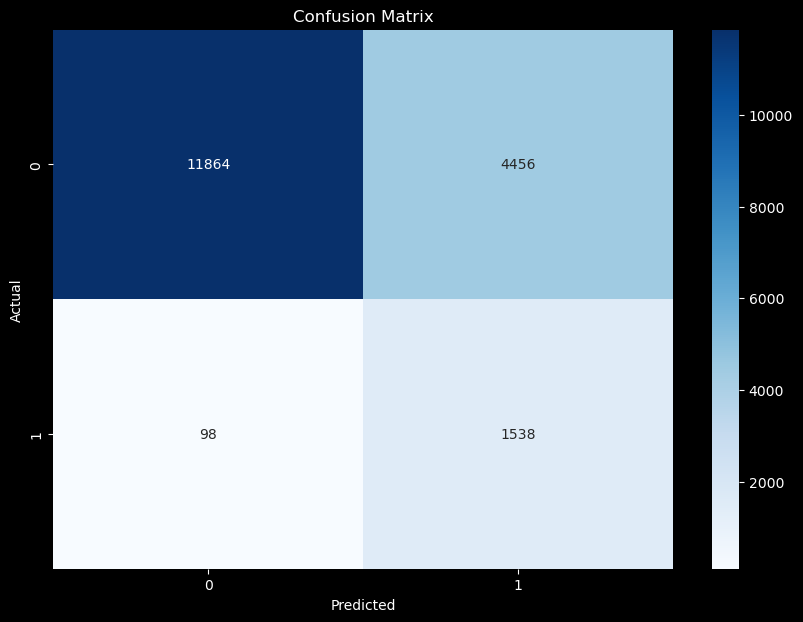

In [133]:
accuracy = accuracy_score(testLabels, y_pred)
classification_report_dict = classification_report(testLabels, y_pred, output_dict=True)

# Calculate accuracy
accuracy = accuracy_score(testLabels, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate F1 score
f1 = f1_score(testLabels, y_pred)
print(f'F1 Score: {f1}')

# Compute confusion matrix
conf_matrix = confusion_matrix(testLabels, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [134]:
prec1 = classification_report_dict["1"]["precision"]
recall1 = classification_report_dict["1"]["recall"]
f1score1 = classification_report_dict["1"]["f1-score"]
support1 = classification_report_dict["1"]["support"]
prec0 = classification_report_dict["0"]["precision"]
recall0 = classification_report_dict["0"]["recall"]
f1score0 = classification_report_dict["0"]["f1-score"]
support0 = classification_report_dict["0"]["support"]

saveString = f"{testPID},{randSeed},{prec1},{recall1},{f1score1},{support1},{prec0},{recall0},{f1score0},{support0},{accuracy},\n"

In [135]:
savePath = "/home/khkolt/Research/TremorProject/Results/"
fname = f"Minglong2023_{testPID}.csv"

In [136]:
with open(savePath+fname, 'a') as file:
    file.write(saveString)

FileNotFoundError: [Errno 2] No such file or directory: '/home/khkolt/Research/TremorProject/Results/Minglong2023_006.csv'